FAKE NEWS DETECTION

In [1]:
import gdown
import zipfile
import pandas as pd
gdown.download('https://drive.google.com/uc?id=1LwRVfDQSa8nXgXmivi8_35Kd7KeixeH-', 'news.zip')
zipfile.ZipFile('news.zip').extractall('news') #since our file is in zip-format, we have to extract it at first
fake, true = pd.read_csv('news/Fake.csv'), pd.read_csv('news/True.csv')

Downloading...
From (original): https://drive.google.com/uc?id=1LwRVfDQSa8nXgXmivi8_35Kd7KeixeH-
From (redirected): https://drive.google.com/uc?id=1LwRVfDQSa8nXgXmivi8_35Kd7KeixeH-&confirm=t&uuid=fdab1bba-af9c-49d4-8068-c44f9fb826f4
To: /content/news.zip
100%|██████████| 43.0M/43.0M [00:01<00:00, 33.8MB/s]


Then we are converting categorical labels to numeric values. For this, the Label Encoder is imported from the sklearn.preprocessing library.

In [2]:
from sklearn.preprocessing import LabelEncoder
fake['label'] = 'fake'
true['label'] = 'true'
df = pd.concat([fake, true], axis=0).sample(frac=1).reset_index(drop=True)
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])
df.head(5)

,title,text,subject,date,label,label_encoded
0,Jimmy Carter: ‘Koreans Want Peace Treaty to Re...,21st Century Wire says Reframing the current d...,Middle-east,"September 7, 2017",fake,0
1,"For Trump's defenders, White House turmoil is ...","WASHINGTON (Reuters) - In Washington, the chat...",politicsNews,"May 18, 2017",true,1
2,"The Numbers Are In: States, Insurers Literall...","This morning, Donald Trump tweeted that health...",News,"October 29, 2017",fake,0
3,UK government softens immigration rules for Gr...,LONDON (Reuters) - Illegal immigrants who surv...,worldnews,"October 11, 2017",true,1
4,WOW! WASHED UP LIBERAL CHER Uses Tweet About F...,Translation: I m so sorry for your loss but wa...,politics,"Jul 15, 2016",fake,0


Fake: 23481, Real: 21417


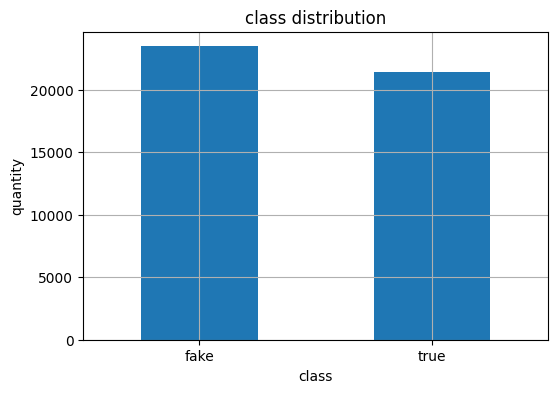

In [3]:
#checking the balance of the classes
print(f"Fake: {len(fake)}, Real: {len(true)}")
#visualizing
import matplotlib.pyplot as plt
counts = df ['label'].value_counts()
plt.figure(figsize=(6,4))
counts.plot(kind = 'bar')
plt.title ('class distribution')
plt.grid ()
plt.xlabel ('class')
plt.ylabel ('quantity')
plt.xticks (rotation = 0)
plt.show ()

We can say that the imbalance is not too strong, and the model is likely to be able to train well without special data balancing measures.

In [4]:
#preprocssing the data
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
import spacy
import nltk
import re
from nltk.corpus import stopwords
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
nlp = spacy.load('en_core_web_sm')
def text_preprocess(text):
    text = text.lower() #lowercase
    text = re.sub(r'[^\w\s]', '', text) # punctuation and special characters removing
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english')) #stopwords
    tokens = [word for word in tokens if word not in stop_words]
    doc = nlp(" ".join(tokens))
    tokens = [token.lemma_ for token in doc]
    return " ".join(tokens)
df['text_preprocess'] = df['text'].apply(text_preprocess)
print("Original text:\n", df['text'].iloc[0][:200], "...")
print("\nProcessed text:\n", df['text_preprocess'].iloc[0][:200], "...")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Original text:
 21st Century Wire says Reframing the current diplomatic crisis in North Korea is essential if genuine progress is to be made in diffusing the current tense situation.Former US President Jimmy Carter i ...

Processed text:
 21st century wire say reframe current diplomatic crisis north korea essential genuine progress make diffuse current tense situationformer us president jimmy carter suggest hawk washington listen carte ...


In [6]:
# Splitting the data into training and testing sets
from sklearn.model_selection import train_test_split

X = df['text_preprocess']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Vectorizing the text data
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [8]:
# Training a machine learning model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [9]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000)

In [10]:

y_pred = model.predict(X_test_tfidf)
# Evaluating our model
print("\nModel Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Model Evaluation:
Accuracy: 0.9838530066815144

Classification Report:
               precision    recall  f1-score   support

        fake       0.99      0.98      0.98      4717
        true       0.98      0.99      0.98      4263

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980


Confusion Matrix:
 [[4632   85]
 [  60 4203]]


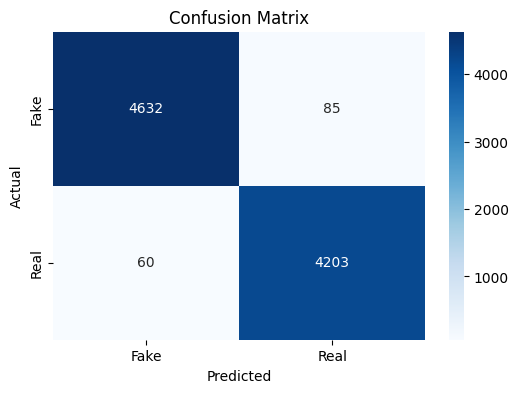

In [11]:
 # confusion matrix
import seaborn as sns
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake', 'Real'],
            yticklabels=['Fake', 'Real'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

The overall accuracy is very high — about 99%, which indicates the high efficiency of the model.